In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
# Importing the dataset
file_name = "frequency_data"
data = pd.read_csv(f"data/cleaned_data/{file_name}.csv")

dtypes = pd.read_csv(f"data/cleaned_data/{file_name}_dtypes.csv", index_col=0)
data = data.astype(dtypes.to_dict()["0"])

data["datetime"] = data["time"]
data.drop("time", axis=1, inplace=True)


In [5]:
def filter_room_id(data, room_id):
    return data[data["room_id"] == room_id].reset_index(drop=True)

def filter_event_type(data, event_type):
    return data[data["event_type"] == event_type].reset_index(drop=True)

In [5]:
## only one lecture hall
#data = filter_room_id(data, 0)
## only entering events
#data = filter_event_type(data, 1)

# 0. Adjustments and Transforms

Once decided think of suitable transforms -> claendar adjustments etc.

Or try box-cox transform

# 1. Basic Visualizations

## 1.0 Prepare Data

In [6]:
data_filterd = filter_room_id(data, 0)
del data
data_filterd = filter_event_type(data_filterd, 1)

def resample(data, time_column, frequency, agg_func):
    
    # get min day
    if frequency == "MS":
        min_time = min(data[time_column]).replace(day=1, hour=0, minute=0, second=0)
    else:
        min_time = min(data[time_column]).replace(hour=0, minute=0, second=0)

    # get max day
    max_time = max(data[time_column])
    max_time = max_time.replace(day=max_time.day+1, hour=0, minute=0, second=0)
    
    
    idx = pd.date_range(start=min_time, end=max_time, freq=frequency, inclusive="both") 

    df_resampled = data.set_index(time_column)\
                   .resample(frequency, label="left", closed="left")

    if agg_func == "sum":
        df_resampled = df_resampled.sum()
    elif agg_func == "count":
        df_resampled = df_resampled.count()
    elif agg_func == "value_counts":
        df_resampled = df_resampled.value_counts()
    else:
        raise ValueError("agg_func must be 'sum', 'count' or 'value_counts'")
    return df_resampled.reindex(idx, fill_value=0).reset_index().rename(columns={"index": time_column})[[time_column, "event_type"]]


In [7]:
#offset_week = pd.tseries.offsets.Week(weekday=0)
#offset_month = "MS"
#data_resampled = resample(data_filterd, "datetime", offset_week, "count")

## 1.1 Basic Time Plot

In [8]:
# Plotting the data
data_resampled = resample(data_filterd, "datetime", "15min", "count")
fig = go.Figure()
# line plot
fig.add_trace(go.Scatter(x=data_resampled["datetime"], y=data_resampled["event_type"], mode='lines', name='lines'))


## 1.2 Time Series Patterns

### Also plot the respective ACF plots

In [9]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("per Hour", "Per Day", "Per Week", "Per Month"))


freq = "1h"
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="hour"
    ),
    row=1, col=1
)

freq = "1d"
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="day"
    ),
    row=1, col=2
)

freq = pd.tseries.offsets.Week(weekday=0)
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="week"
    ),
    row=2, col=1
)

freq = "MS"
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="month"
    ),
    row=2, col=2
)

fig.show()

del data_resampled

## 1.3 Seasonal Plots

Could be averaged or aggregated over weeks

In [10]:
def derive_day(data):
    data["day"] = data["datetime"].dt.date
    return data

def derive_week(data):
    data["week"] = data["datetime"].dt.isocalendar().week
    return data

def derive_time(data):
    data["time"] = data["datetime"].dt.time
    return data

### 1.3.1 Compare Days

In [11]:
# Plot daily patterns

data_resampled = resample(data_filterd, "datetime", "15min", "count")
data_resampled = derive_day(data_resampled)
data_resampled = derive_time(data_resampled)

fig = px.line(data_resampled, x="time", y="event_type", color="day")
fig.show()
del data_resampled

In [12]:
#fig = go.Figure()

#for day in data_resampled["day"].unique():
#    fig.add_trace(go.Scatterpolar(
#        r=data_resampled[data_resampled["day"]==day]["event_type"],
#        theta=data_resampled[data_resampled["day"]==day]["time"], 
#        mode='lines',
#        name=str(day),
#    ))

#fig.update_layout(
#    polar=dict(
#        angularaxis=dict(
#            direction="clockwise",
#            dtick=2,
#        )
#    ),
#    height=750,
#    width=1000,
#    showlegend=True,
#    margin=dict(l=0, r=0, t=35, b=35)
#)

### 1.3.2 Compare Weeks


In [13]:
def exclude_weekdays(data, weekdays):
    data["dayofweek"] = data["datetime"].dt.dayofweek
    return data[~data["dayofweek"].isin(weekdays)]

In [14]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")
#data_resampled = derive_day(data_resampled)
data_resampled = derive_time(data_resampled)
data_resampled = derive_week(data_resampled)
#data_resampled = exclude_weekdays(data_resampled, [6,7])

data_resampled = data_resampled.drop("datetime", axis=1)

#sum
data_resampled = data_resampled.groupby(["week", "time"]).sum().reset_index()
#mean
#data_resampled = data_resampled.groupby(["week", "time"]).median().reset_index()

fig = px.line(data_resampled, x="time", y="event_type", color="week")
fig.show()
del data_resampled

## 1.4 Autocorrelation Plot

In [15]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")

data_resampled.head()

,datetime,event_type
0,2024-04-08 00:00:00,0
1,2024-04-08 00:15:00,0
2,2024-04-08 00:30:00,0
3,2024-04-08 00:45:00,0
4,2024-04-08 01:00:00,0


In [16]:
data_resampled.loc[96]

datetime      2024-04-09 00:00:00
event_type                      0
Name: 96, dtype: object

In [17]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")

lag_list = list(range(0, 1000))
auto_corr = [data_resampled["event_type"].autocorr(lag=i) for i in lag_list]

#fig.add_trace(go.bar(x=data_resampled["datetime"], y=data_resampled["event_type"], mode='lines', name='lines'))

fig = go.Figure()
# line plot
fig.add_trace(
    go.Bar(
        x=lag_list,
        y=auto_corr,
        name='Auto Correlation'
    )
)
del auto_corr
del lag_list
del data_resampled

# 2. Simple Forcasting methods

In [18]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")
dataset = data_resampled[data_resampled["datetime"] < datetime(2024, 6, 24)]

trainset = dataset[dataset["datetime"] < datetime(2024, 6, 10)].set_index("datetime").copy()
testset = dataset[dataset["datetime"] >= datetime(2024, 6, 10)].set_index("datetime").copy()

del data_resampled
del dataset

In [19]:
def plot_results(train, test, column_name, predictions, method_name):
    plt.figure(figsize=(12,8))
    
    plt.plot(train.index, train[column_name], label='Train')
    plt.plot(test.index, test[column_name], label='Test')    
    plt.plot(predictions.index, predictions, label=method_name)
    
    plt.legend(loc='best')
    plt.show()

## 2.1 Naive methods

In [20]:
y_hat = testset.copy()
y_hat["naive"] = trainset["event_type"][len(trainset)-1]

/tmp/ipykernel_393253/2386040615.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



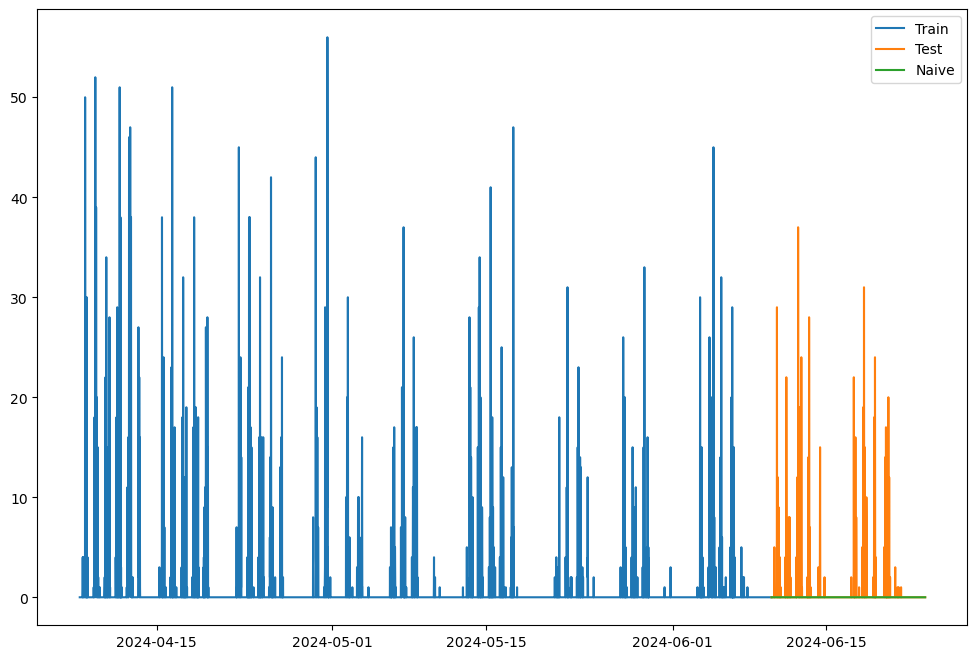

In [21]:
plot_results(trainset, testset, "event_type", y_hat["naive"], "Naive")
del y_hat

## 2.2 Seasonal naive method

In [22]:
season_offset = 4*24*7

In [23]:
y_hat = testset.copy()

preds =  trainset["event_type"][-season_offset:]
preds.index = testset.index[:season_offset]

preds

datetime
2024-06-10 00:00:00    0
2024-06-10 00:15:00    0
2024-06-10 00:30:00    0
2024-06-10 00:45:00    0
2024-06-10 01:00:00    0
                      ..
2024-06-16 22:45:00    0
2024-06-16 23:00:00    0
2024-06-16 23:15:00    0
2024-06-16 23:30:00    0
2024-06-16 23:45:00    0
Name: event_type, Length: 672, dtype: int64

In [24]:

# import mean absolute error and root mean squared error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_results(target_values, predictions):
    # mae
    mae = mean_absolute_error(target_values, predictions)
    # mse
    mse = mean_squared_error(target_values, predictions)
    # mase
    numerator = np.mean(np.abs(target_values - predictions))
    denominator = np.mean(np.abs(target_values[1:] - target_values[:-1]))
    mase = numerator / denominator
    #r2
    r2 = r2_score(target_values, predictions)
    
    # print results
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"Mean Absolute Percentage Error: {mase}")
    print(f"R2 Score: {r2}")
    

evaluate_results(testset["event_type"].values[:season_offset], preds.values)


Mean Absolute Error: 0.6532738095238095
Root Mean Squared Error: 2.8475657942145873
Mean Absolute Percentage Error: 0.7233444326575516
R2 Score: 0.11277466776249478


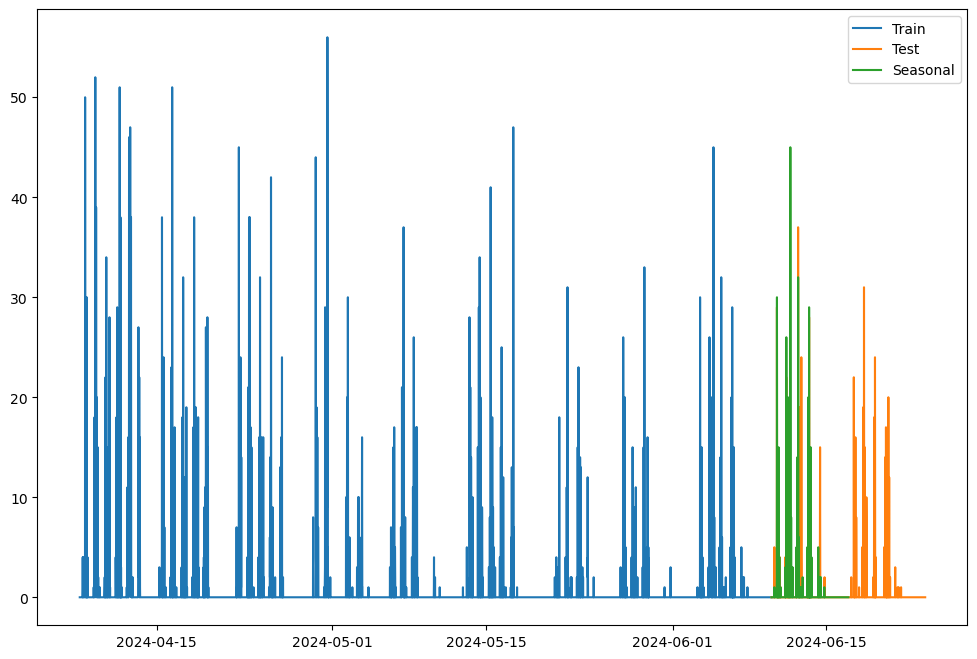

In [25]:
plot_results(trainset, testset, "event_type", preds, "Seasonal")

## 2.3 Linear Regression Models

Only try naive approach -> X = time, Y = Values

We could also add dummy variables

In [26]:
#import linear regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

X = trainset.index.values.astype(float).reshape(-1,1)

Y = trainset["event_type"].values


model = LinearRegression()
model.fit(X, Y)


LinearRegression()

In [27]:
preds = trainset.copy()
preds["linear"] = model.predict(X)
preds["linear"]

datetime
2024-04-08 00:00:00    1.510127
2024-04-08 00:15:00    1.509919
2024-04-08 00:30:00    1.509711
2024-04-08 00:45:00    1.509503
2024-04-08 01:00:00    1.509295
                         ...   
2024-06-09 22:45:00    0.253271
2024-06-09 23:00:00    0.253063
2024-06-09 23:15:00    0.252855
2024-06-09 23:30:00    0.252647
2024-06-09 23:45:00    0.252439
Name: linear, Length: 6048, dtype: float64

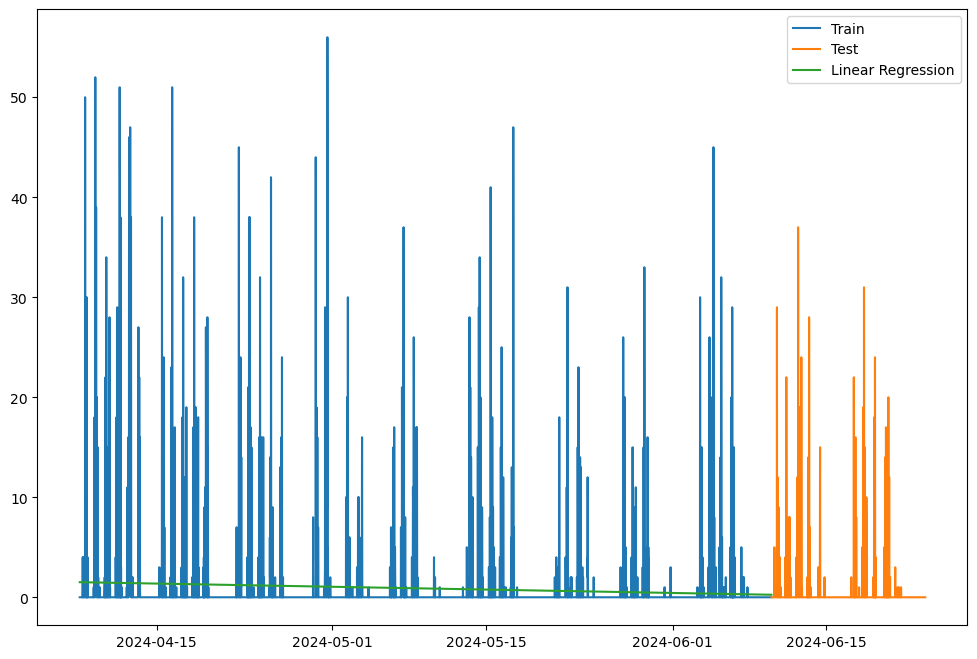

In [28]:
plot_results(trainset, testset, "event_type", preds["linear"], "Linear Regression")

## Add dummy variables

In [29]:
import statsmodels.api as sm

In [30]:
week_day_dummmies = pd.get_dummies(trainset.index.day_of_week, drop_first=False)
hour_dummies = pd.get_dummies(trainset.index.hour, drop_first=False)
minute_dummies = pd.get_dummies(trainset.index.minute, drop_first=True)

In [31]:
train_linspace = np.linspace(0, 10, len(X))
X_concat = np.concatenate((train_linspace.reshape(-1, 1), week_day_dummmies.values, hour_dummies.values, minute_dummies.values), axis=1)
X_concat = sm.add_constant(X_concat)

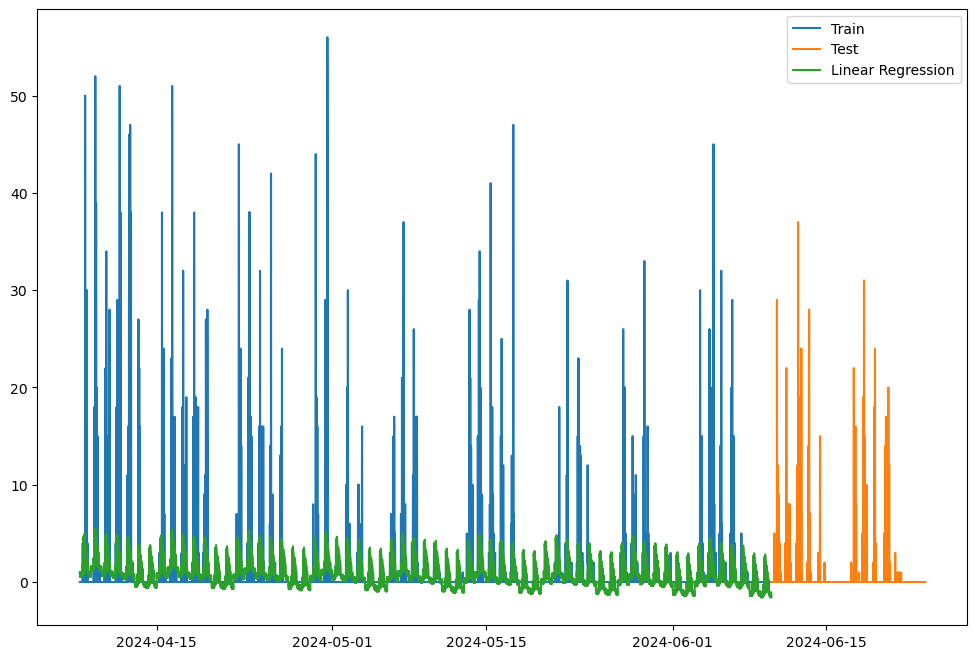

In [32]:
model = sm.OLS(Y, X_concat)
results = model.fit()
#print(results.summary())

preds = trainset.copy()
preds["linear"] = results.predict(X_concat)

plot_results(trainset, testset, "event_type", preds["linear"], "Linear Regression")

In [33]:
step_size = 10/len(X)
test_linspace = np.linspace(0, step_size * len(testset), len(testset)) + 10 + step_size

In [34]:
week_day_dummmies = pd.get_dummies(testset.index.day_of_week, drop_first=False)
hour_dummies = pd.get_dummies(testset.index.hour, drop_first=False)
minute_dummies = pd.get_dummies(testset.index.minute, drop_first=True)

X_test = np.concatenate((test_linspace.reshape(-1, 1), week_day_dummmies.values, hour_dummies.values, minute_dummies.values), axis=1)
X_test = sm.add_constant(X_test)

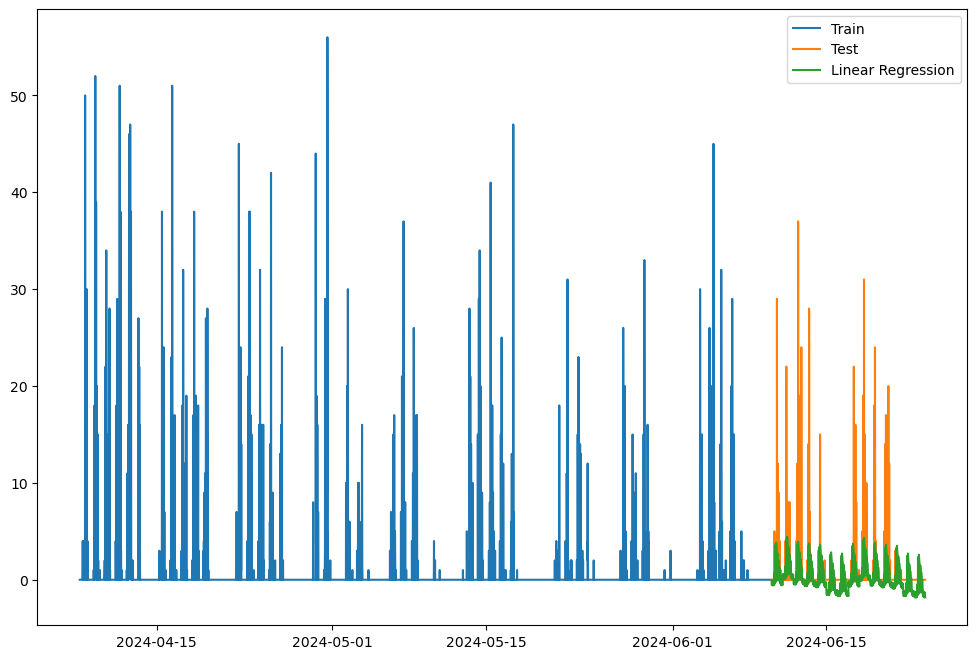

In [35]:
preds = testset.copy()
preds["linear"] = results.predict(X_test)

plot_results(trainset, testset, "event_type", preds["linear"], "Linear Regression")

# 3. Time Series Decomposition

## 3.1 Seasonal decomposition

Very nice!

### 3.1.1 Naive decomposition

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL

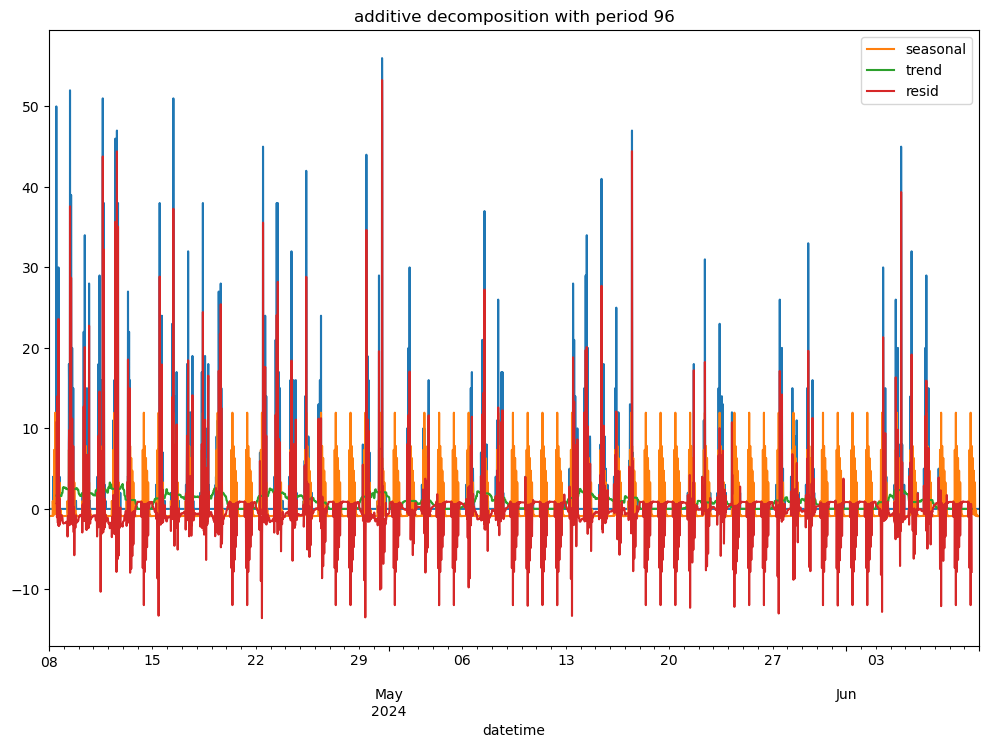

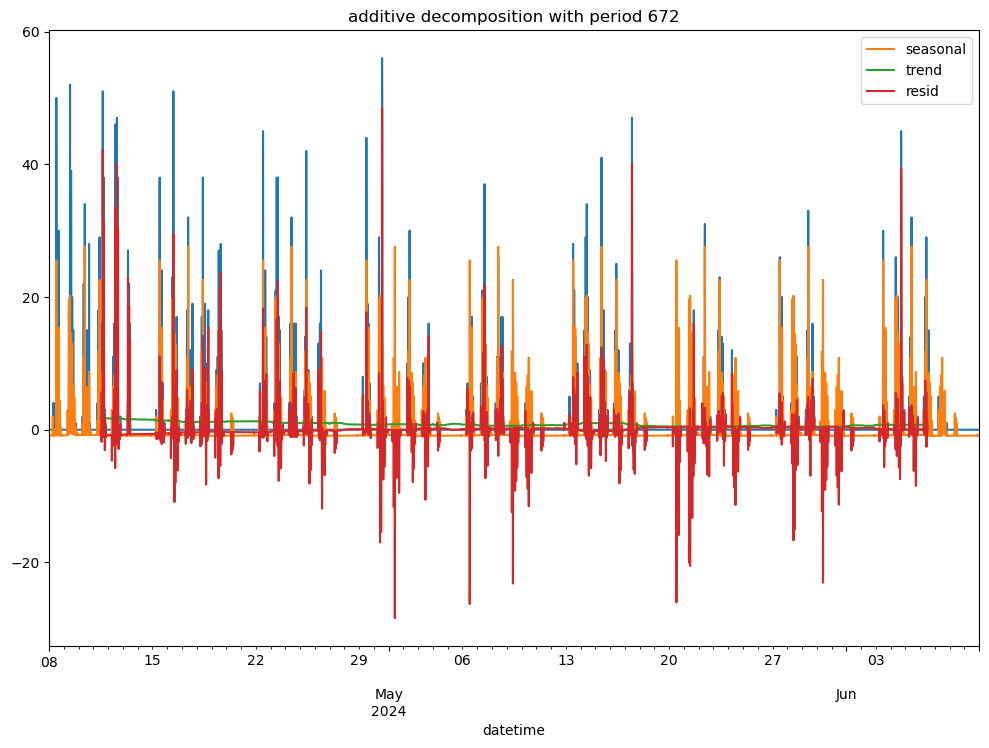

In [37]:
plot_df = trainset.copy()

periods = [4*24, 4*24*7]
models = ["additive"]
for model in models:
    for period in periods:
        results = seasonal_decompose(plot_df, model=model, period=period)

        plt.figure(figsize=(12,8))

        results.observed.plot()
        results.seasonal.plot()
        results.trend.plot()
        results.resid.plot()
        plt.title(f"{model} decomposition with period {period}")
        plt.legend(loc='best')
        plt.show()

### 3.1.2 STL/MSTL 


3576.190391782592


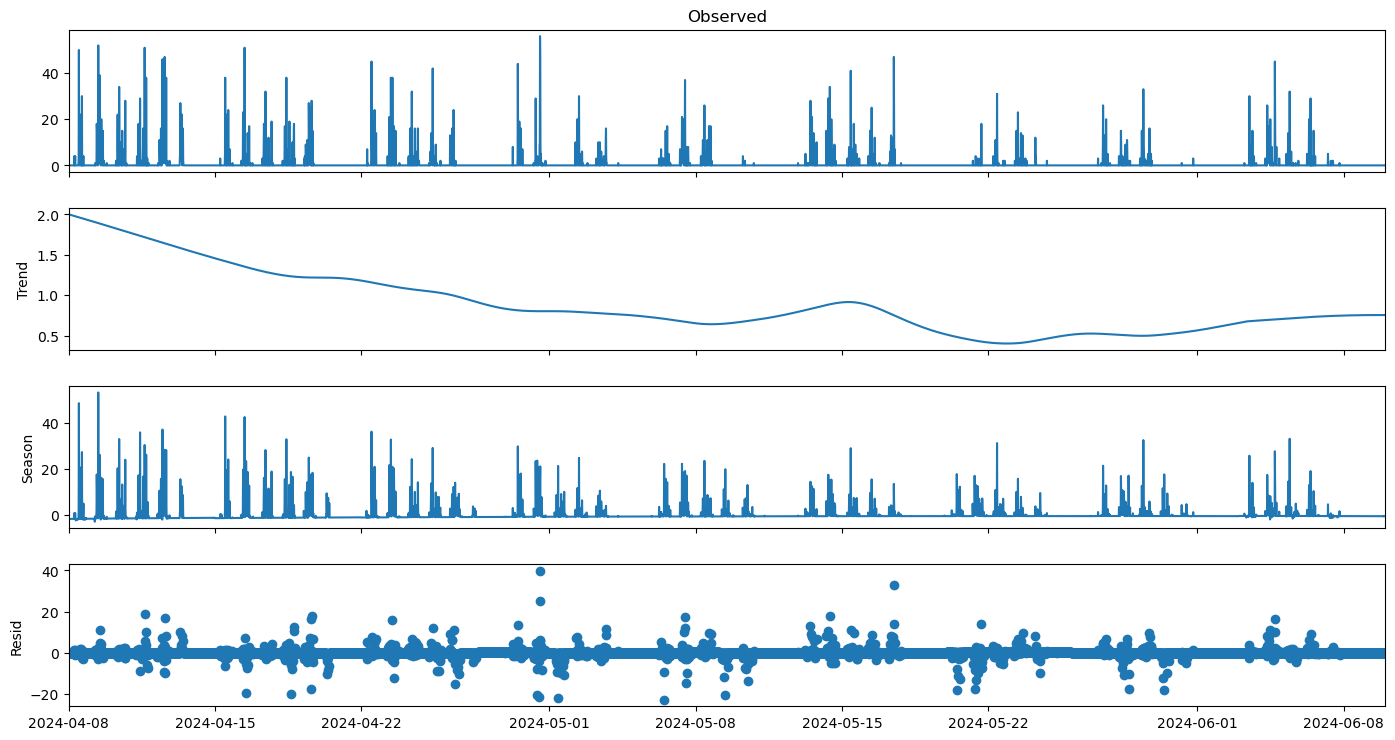

In [38]:
plot_df = trainset.copy()

results = STL(plot_df, period=4*24*7).fit()
print(np.sum(np.abs(results.resid)))

fig = results.plot()
fig.set_size_inches((16, 8))
plt.show()

4027.2509793196505


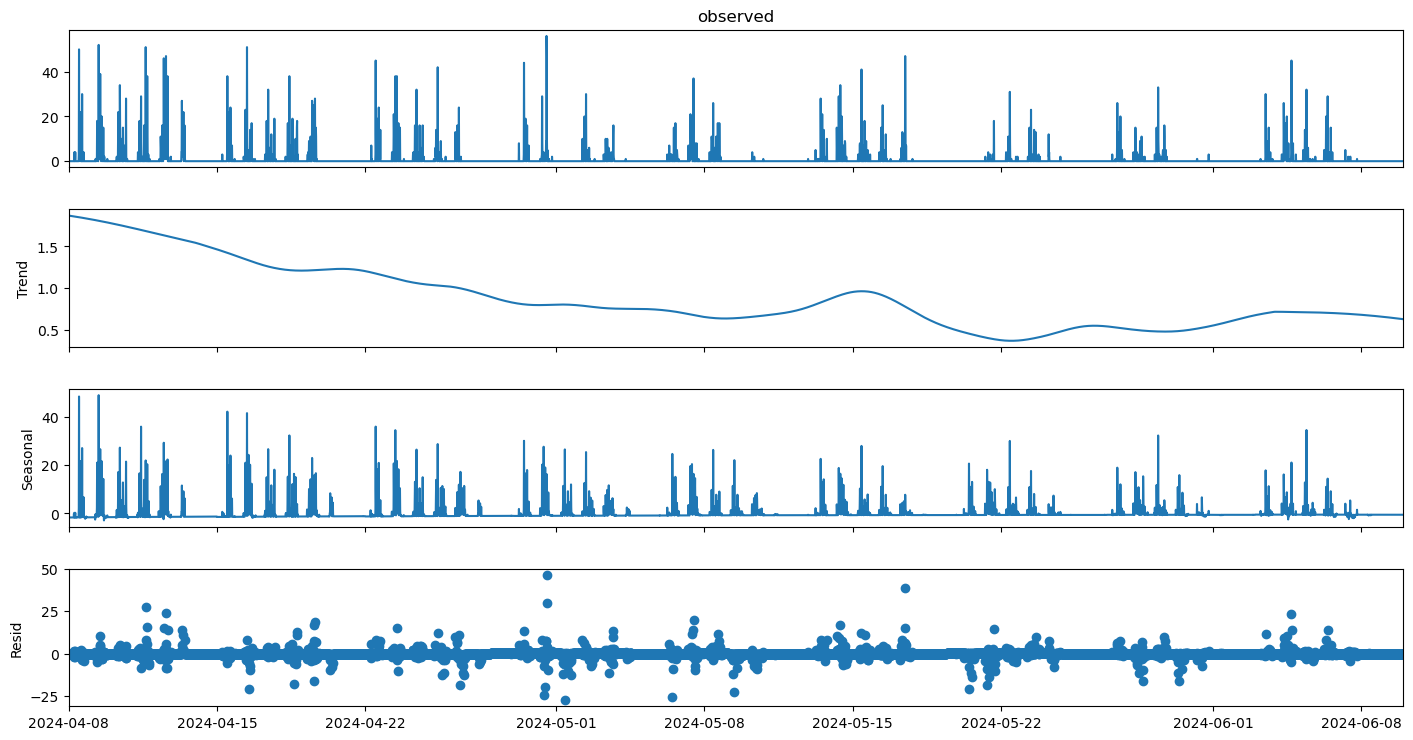

In [39]:
plot_df = trainset.copy()

results = MSTL(plot_df, 
               periods=[4*24*7]).fit()
print(np.sum(np.abs(results.resid)))

fig = results.plot()
fig.set_size_inches((16, 8))
plt.show()


# 4. Exponential Smoothing

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

## 4.1 Simple Exponential Smoothing

Only applicable if no trend or seasonal component only depends on past

/home/berni/anaconda3/envs/webapp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 15min will be used.

/home/berni/anaconda3/envs/webapp/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning



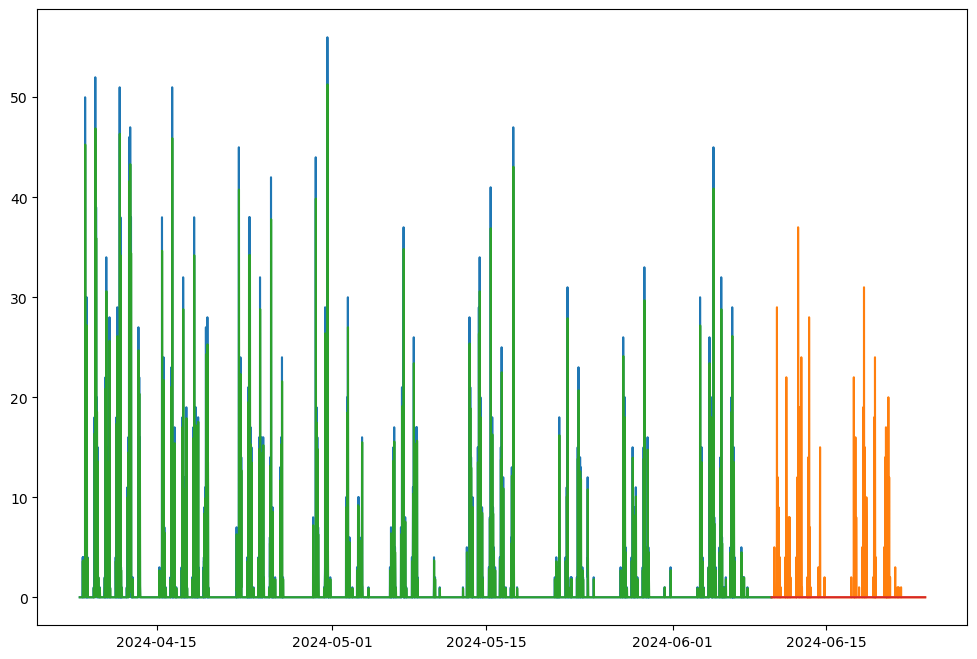

In [41]:

model = SimpleExpSmoothing(trainset["event_type"])
results = model.fit(smoothing_level=0.9)

fig = plt.figure(figsize=(12,8))


plt.plot(trainset["event_type"], label="Trainset")
plt.plot(testset["event_type"], label="Testset")

plt.plot(results.fittedvalues, label="Fitted")
plt.plot(results.forecast(len(testset)), label="Forecast")
#plt.plot(results.resid, label="Fitted")

plt.show()


## 4.2 Holts Trend forcasting

# TODO: Find out why it does not work

In [42]:
from statsmodels.tsa.api import ExponentialSmoothing, Holt, ETSModel

                       ExponentialSmoothing Model Results                       
Dep. Variable:               event_type   No. Observations:                 6048
Model:             ExponentialSmoothing   SSE                          42770.623
Optimized:                         True   AIC                          13184.637
Trend:                         Additive   BIC                          17725.603
Seasonal:                      Additive   AICC                         13356.664
Seasonal Periods:                   672   Date:                 Wed, 17 Jul 2024
Box-Cox:                          False   Time:                         15:42:49
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.0975526                alpha                 True
smoothing_trend       

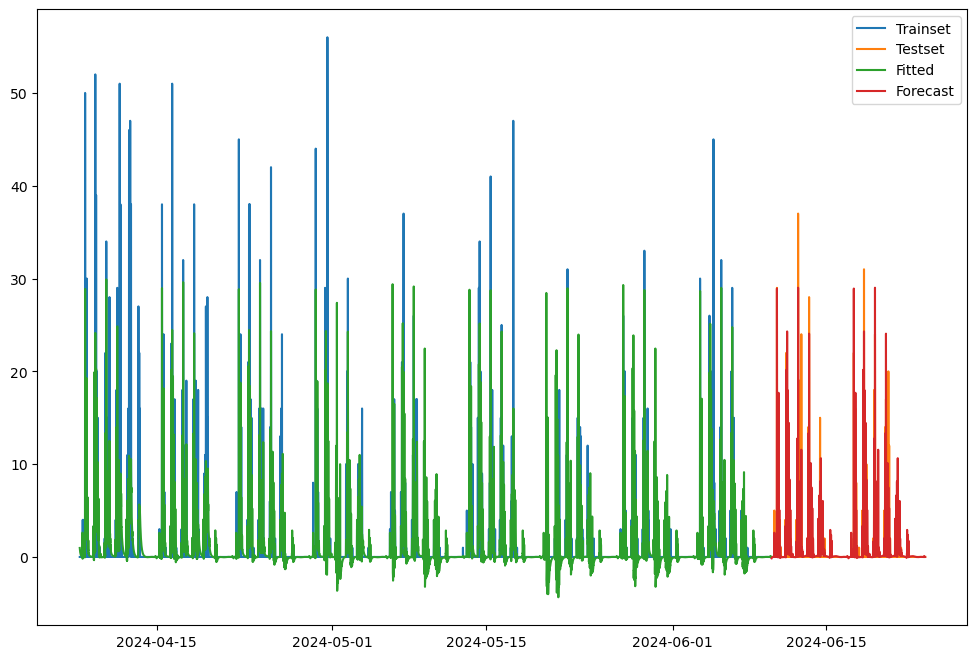

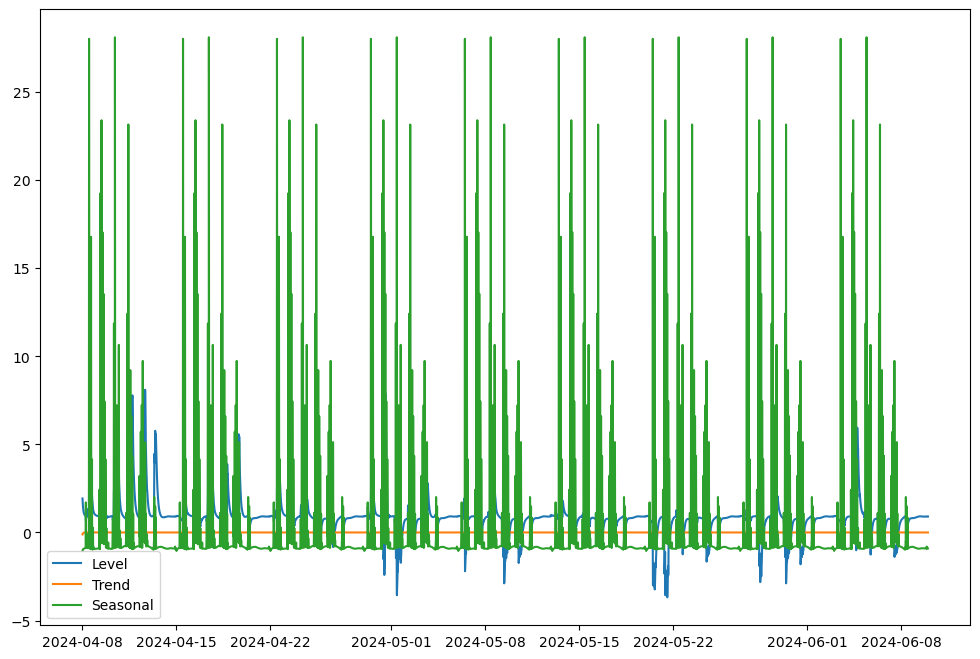

In [43]:

#for dampend_trend in [True]:
    
#    model = ExponentialSmoothing(trainset["event_type"], 
#                                trend="add", seasonal="add",
#                                damped_trend=dampend_trend, 
#                                seasonal_periods=4*24*7,
#                                freq="15min",
#                                initialization_method='estimated')

#    results = model.fit(optimized=True)
#    print(results.summary())

#    # plot forecast etc.
#    fig = plt.figure(figsize=(12,8))

#    plt.plot(trainset["event_type"], label="Trainset")
#    plt.plot(testset["event_type"], label="Testset")

#    plt.plot(results.fittedvalues, label="Fitted")
#    plt.plot(results.forecast(len(testset)), label="Forecast")
#    plt.legend(loc='best')
#    plt.show()

#    # plot components
#    fig = plt.figure(figsize=(12,8))

#    plt.plot(results.level, label="Level")
#    plt.plot(results.trend, label="Trend")
#    plt.plot(results.season, label="Seasonal")

#    plt.legend(loc='best')
#    plt.show()


In [44]:
#for dampend_trend in [True]:
    
#    model = ETSModel(trainset["event_type"], 
#                    error="add",
#                    trend="add", 
#                    seasonal="add",
#                    damped_trend=dampend_trend, 
#                    seasonal_periods=4*24*7,
#                    freq="15min")

#    results = model.fit(maxiter=5)
#    print(results.summary())

#    # plot forecast etc.
#    fig = plt.figure(figsize=(12,8))

#    plt.plot(trainset["event_type"], label="Trainset")
#    plt.plot(testset["event_type"], label="Testset")

#    plt.plot(results.fittedvalues, label="Fitted")
#    plt.plot(results.forecast(len(testset)), label="Forecast")
#    plt.legend(loc='best')
#    plt.show()

#    # plot components
#    fig = plt.figure(figsize=(12,8))
    
#    plt.legend(loc='best')
#    plt.show()

# 5. ARIMA Models

## 5.1 Stationarity

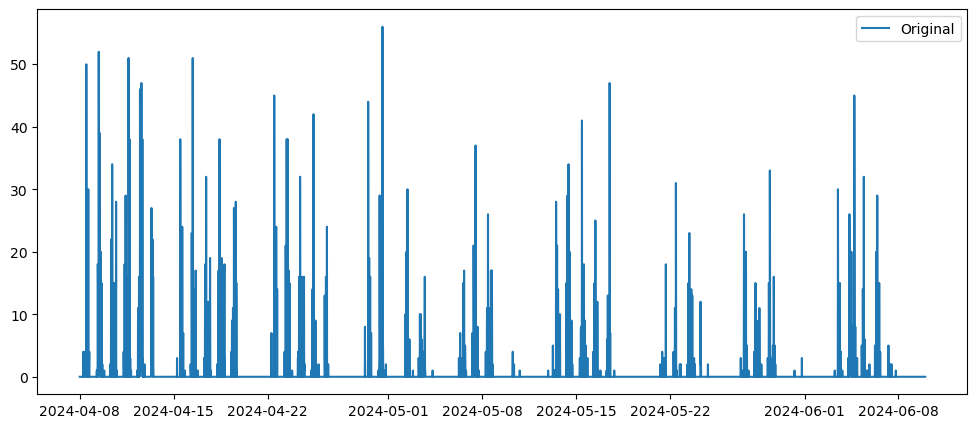

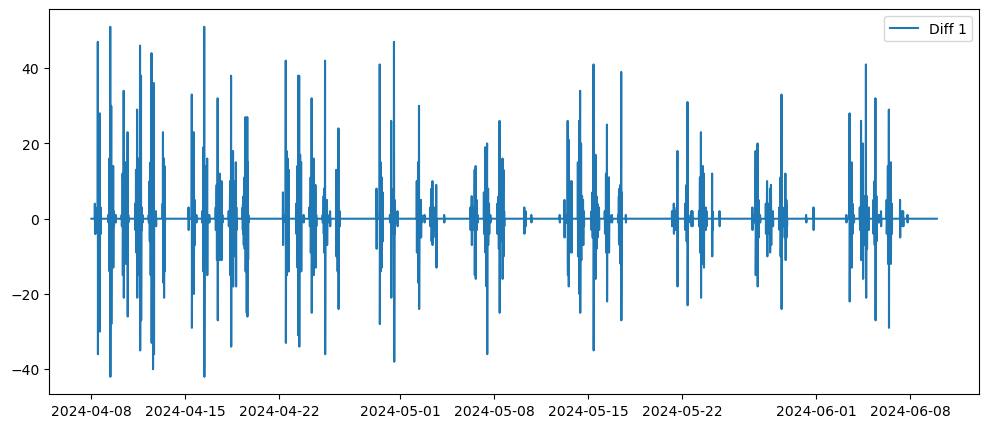

In [45]:
# differencing
stationarity_data = trainset.copy()

lag = 1
stationarity_data[f"event_type_diff_{lag}"] = stationarity_data["event_type"] - stationarity_data["event_type"].shift(lag)
lag = 4*24
stationarity_data[f"event_type_diff_{lag}"] = stationarity_data["event_type"] - stationarity_data["event_type"].shift(lag)
lag = 4*24*7
stationarity_data[f"event_type_diff_{lag}"] = stationarity_data["event_type"] - stationarity_data["event_type"].shift(lag)

fig = plt.figure(figsize=(12,5))
plt.plot(stationarity_data["event_type"], label="Original")
plt.legend(loc='best')
plt.show()

fig = plt.figure(figsize=(12,5))
plt.plot(stationarity_data["event_type_diff_1"], label="Diff 1")
plt.legend(loc='best')
plt.show()

#fig = plt.figure(figsize=(12,5))
#plt.plot(stationarity_data["event_type_diff_96"], label="Diff 96")
#plt.legend(loc='best')
#plt.show()

#fig = plt.figure(figsize=(12,5))
#plt.plot(stationarity_data["event_type_diff_672"], label="Diff 672")
#plt.legend(loc='best')
#plt.show()




In [46]:
stationarity_data["event_type_diff_1"].dropna() 

datetime
2024-04-08 00:15:00    0.0
2024-04-08 00:30:00    0.0
2024-04-08 00:45:00    0.0
2024-04-08 01:00:00    0.0
2024-04-08 01:15:00    0.0
                      ... 
2024-06-09 22:45:00    0.0
2024-06-09 23:00:00    0.0
2024-06-09 23:15:00    0.0
2024-06-09 23:30:00    0.0
2024-06-09 23:45:00    0.0
Name: event_type_diff_1, Length: 6047, dtype: float64

In [47]:
# To check if differencing is needed:
# Tests look book

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    
# null hypothesis: has unit root
# alternative hypothesis: has no unit root
# if p <= alpha: reject null hypothesis -> data is likely stationary
# if p > alpha: fail to reject null hypothesis -> data is likely non-stationary

adf_test(stationarity_data["event_type_diff_1"].dropna())

Results of Dickey-Fuller Test:


Test Statistic                  -21.275862
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    6020.000000
Critical Value (1%)              -3.431437
Critical Value (5%)              -2.862020
Critical Value (10%)             -2.567026
dtype: float64


In [48]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# Book: Small p value -> suggests that differencing is required
kpss_test(stationarity_data["event_type_diff_1"].dropna() )

Results of KPSS Test:
Test Statistic            0.007985
p-value                   0.100000
Lags Used                90.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_393253/3253710021.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




# Check in what case you are: KPSS vs ADF result

## 5.2 Simple Models

In [49]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

### 5.2.1 Non-seasonal Arima

In [50]:
n_lags = 1000
lag_list = list(range(0, n_lags))

fig = go.Figure()
acf_array = acf(trainset["event_type"], nlags=n_lags) 
fig.add_trace(
    go.Bar(
        x=lag_list,
        y=acf_array,
        name='Auto Correlation'
    )
)
pacf_array = pacf(trainset["event_type"], nlags=n_lags) 
fig.add_trace(
    go.Bar(
        x=lag_list,
        y=pacf_array,
        name='Partial Auto Correlation'
    )
)

fig.show()
critical_value = 1.96 / np.sqrt(len(trainset))
#fig.add_hline(y=critical_value, line_width=1, line_dash="dot", line_color="black")
#fig.add_hline(y=-critical_value, line_width=1, line_dash="dot", line_color="black")

### Insights:

* ACF is could be considered sinusoidal -> ARIMA(p,d,0)

In [51]:
from statsmodels.tsa.api import SARIMAX

In [52]:
# method can be handled dynamically!
# use append to handle new data

differences = trainset["event_type"]
model = SARIMAX(differences,
              order=(7, 1, 0),
              freq="15min")

results = model.fit()

print(results.summary())

# plot forecast etc.
fig = plt.figure(figsize=(12,5))

plt.plot(trainset["event_type"], label="Trainset")
plt.plot(testset["event_type"], label="Testset")

plt.plot(results.forecast(len(testset)), label="Forecast")
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(results.resid)
ax[1].plot(acf(results.resid, nlags=1000))
plt.show()